In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-06-22 08:57:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.006s  

2023-06-22 08:57:20 (28.8 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [ ]:
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates = ["Date"], index_col = ["Date"])

In [ ]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)" : "Prices"})
bitcoin_prices

,Prices
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


<Axes: xlabel='Date'>

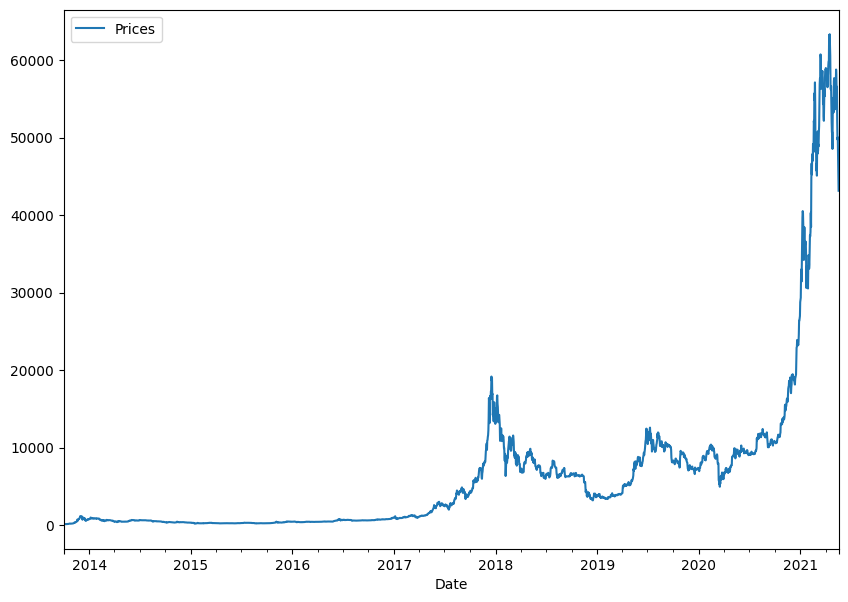

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize = (10,7))

In [ ]:
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))


In [ ]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Prices"].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(timesteps, prices, test_size = 0.2, random_state = 42)

In [ ]:

split_size = int(0.8 * len(prices))
X_train, Y_train = timesteps[:split_size], prices[:split_size]
X_test, Y_test = timesteps[split_size:], prices[split_size:]

In [ ]:
def plot_time_series(timesteps, values, format = ".", start = 0, end = None, label = None):

  plt.plot(timesteps[start:end], values[start:end], format, label = label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize = 14,)
  plt.grid(True)

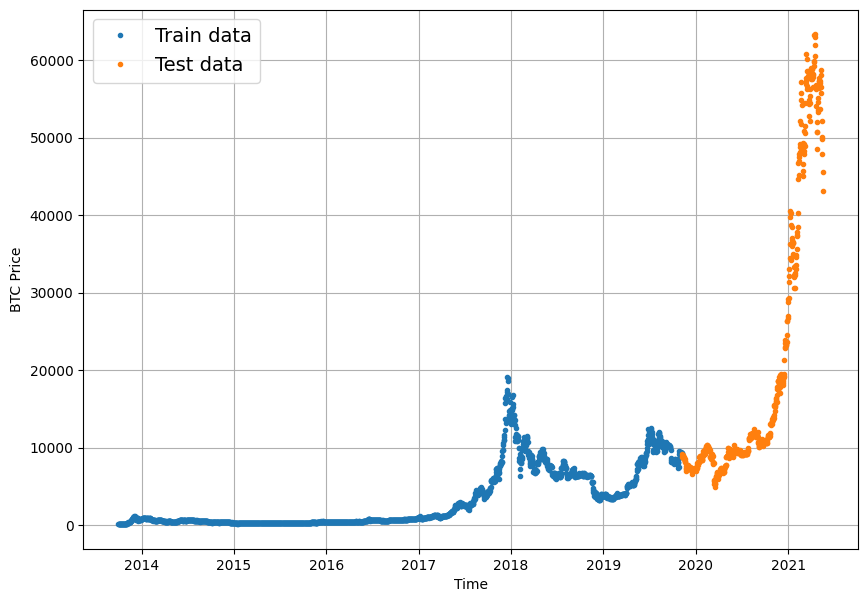

In [ ]:
plt.figure(figsize = (10,7))
plot_time_series(timesteps = X_train, values = Y_train, label = "Train data")
plot_time_series(timesteps = X_test, values = Y_test, label = "Test data")

In [ ]:
naive_forecast = Y_test[:-1]

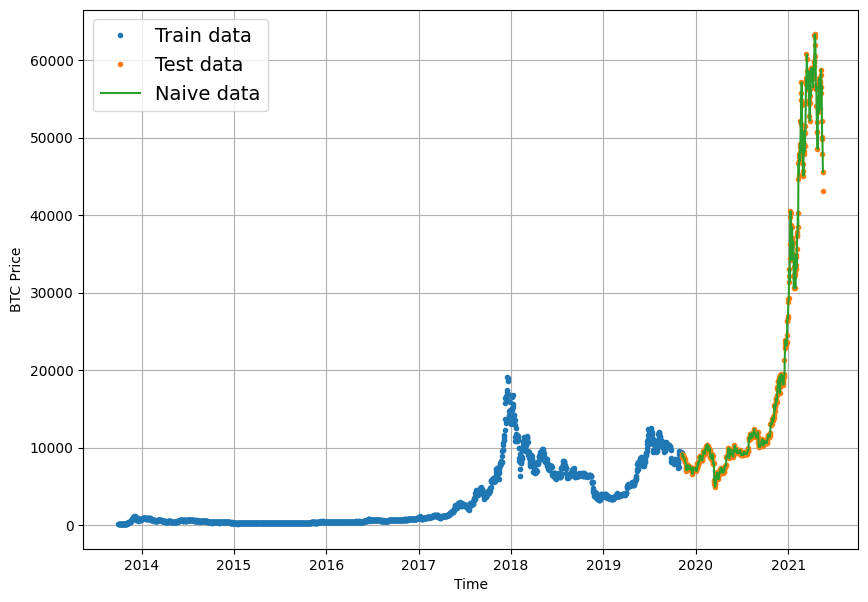

In [ ]:
plt.figure(figsize = (10, 7))
plot_time_series(timesteps = X_train, values = Y_train, label = "Train data")
plot_time_series(timesteps = X_test, values = Y_test, label = "Test data")
plot_time_series(timesteps = X_test[1:], values = naive_forecast, format = "-", label = "Naive data")

In [ ]:
import tensorflow as tf
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season

In [ ]:
mean_absolute_scaled_error(y_true = Y_test[1:], y_pred = naive_forecast )

<tf.Tensor: shape=(), dtype=float64, numpy=0.9995699939182624>

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
def get_labelled_window(x, horizon = HORIZON):
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
import numpy as np

def make_windows(x, window_size = WINDOW_SIZE, horizon = HORIZON):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis = 0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon -1)), axis = 0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_window(windowed_array, horizon = horizon)
  return windows, labels

In [ ]:

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)


In [ ]:
def make_train_test_split(windows, labels, test_split = 0.2):
  split_size = int(len(windows)*(1-test_split))
  train_windows = windows[:split_size]
  train_labels =  labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, train_labels, test_windows, test_labels

In [ ]:
train_windows, train_labels, test_windows, test_labels = make_train_test_split(full_windows, full_labels)

In [ ]:
import os

def create_model_checkpoint(model_name, save_path = "model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name), save_best_only = True, verbose = 0)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    tf.keras.Input(shape = (7,)),
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON, activation = "linear")
])

model_1.compile(loss = "mae", optimizer = tf.keras.optimizers.Adam(lr = 0.0003), metrics = ["mae", "mse"])

model_1.fit(train_windows, train_labels, epochs = 100, batch_size = 128, validation_data = (test_windows, test_labels), callbacks = [create_model_checkpoint(model_name = model_1.name)], verbose = 1)

Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)


  return {"mae": mae.numpy(),
             "mse": mse.numpy(),
           "rmse": rmse.numpy(),
           "mape": mape.numpy(),
           "mase": mase.numpy()}




In [ ]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)

In [ ]:
train_windows, train_labels, test_windows, test_labels = make_train_test_split(full_windows, full_labels, test_split =0.2)


In [ ]:
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON)
])

model_2.compile(loss = "mae", optimizer = tf.keras.optimizers.Adam(lr = 0.0003))
model_2.fit(train_windows, train_labels, epochs = 100, batch_size = 128, validation_data = (test_windows, test_labels), callbacks = [create_model_checkpoint(model_name = model_2.name)], verbose = 1)


NameError: ignored

In [ ]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 723.4460


723.4459838867188

In [ ]:
model_2 = tf.keras.models.load_model("/content/model_experiments/sequential_2")

In [ ]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 616.3024


616.3024291992188

In [ ]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
12/18 [===================>..........] - ETA: 0s - loss: 1940.0270 

18/18 [==============================] - 2s 51ms/step - loss: 1512.0592 - val_loss: 4240.4619
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 761.0806

18/18 [==============================] - 1s 29ms/step - loss: 398.3754 - val_loss: 1607.8805
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 245.7155

18/18 [==============================] - 1s 30ms/step - loss: 266.6742 - val_loss: 1375.3396
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 205.3367

18/18 [==============================] - 1s 30ms/step - loss: 238.4472 - val_loss: 1186.7308
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 161.1487

18/18 [==============================] - 1s 30ms/step - loss: 211.3510 - val_loss: 1095.3026
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 240.5248

18/18 [==============================] - 1s 30ms/step - loss: 199.9352 - val_loss: 1090.7332
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 184.1915

18/18 [==============================] - 1s 31ms/step - loss: 177.7496 - val_loss: 966.9298
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 174.6239

18/18 [==============================] - 1s 30ms/step - loss: 174.3983 - val_loss: 931.7414
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 172.9244 - val_loss: 976.9495
Epoch 10/100
18/18 [==============================] - 0s 4ms/step - loss: 165.3994 - val_loss: 954.9193
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 179.6307

18/18 [==============================] - 1s 30ms/step - loss: 159.3341 - val_loss: 849.2640
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 157.9866 - val_loss: 883.5967
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 164.9270

18/18 [==============================] - 1s 29ms/step - loss: 147.8239 - val_loss: 807.9490
Epoch 14/100
18/18 [==============================] - 0s 4ms/step - loss: 162.1004 - val_loss: 823.0826
Epoch 15/100
18/18 [==============================] - 0s 5ms/step - loss: 163.1807 - val_loss: 883.4089
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 156.9052

18/18 [==============================] - 1s 30ms/step - loss: 154.4664 - val_loss: 762.8543
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 145.3764 - val_loss: 1023.9526
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 150.2803 - val_loss: 1052.1274
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 148.0437 - val_loss: 880.2261
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 179.5343

18/18 [==============================] - 1s 53ms/step - loss: 144.0620 - val_loss: 744.5919
Epoch 21/100
18/18 [==============================] - 0s 7ms/step - loss: 145.1086 - val_loss: 842.1964
Epoch 22/100
16/18 [=========================>....] - ETA: 0s - loss: 162.2194

18/18 [==============================] - 1s 44ms/step - loss: 159.0551 - val_loss: 742.9729
Epoch 23/100
18/18 [==============================] - 0s 7ms/step - loss: 138.5696 - val_loss: 944.5104
Epoch 24/100
15/18 [========================>.....] - ETA: 0s - loss: 142.1707

18/18 [==============================] - 1s 43ms/step - loss: 144.9434 - val_loss: 710.3859
Epoch 25/100
18/18 [==============================] - 0s 8ms/step - loss: 128.9597 - val_loss: 804.3873
Epoch 26/100
18/18 [==============================] - 0s 7ms/step - loss: 127.7329 - val_loss: 743.6438
Epoch 27/100
18/18 [==============================] - 0s 7ms/step - loss: 127.1517 - val_loss: 824.0502
Epoch 28/100
18/18 [==============================] - 0s 5ms/step - loss: 135.1247 - val_loss: 1015.8387
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 210.3585

18/18 [==============================] - 1s 32ms/step - loss: 160.2190 - val_loss: 681.3660
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 139.1468 - val_loss: 748.7845
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 138.2494 - val_loss: 711.5840
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 132.1801 - val_loss: 813.2700
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 131.5262 - val_loss: 807.5318
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 129.2236 - val_loss: 720.4715
Epoch 35/100
18/18 [==============================] - ETA: 0s - loss: 124.9331

18/18 [==============================] - 1s 31ms/step - loss: 124.9331 - val_loss: 658.6534
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 131.8951

18/18 [==============================] - 1s 30ms/step - loss: 124.6717 - val_loss: 655.0099
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 122.0472 - val_loss: 739.9127
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 160.7323 - val_loss: 883.2014
Epoch 39/100
18/18 [==============================] - 0s 4ms/step - loss: 133.5063 - val_loss: 658.3770
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 90.3554

18/18 [==============================] - 1s 30ms/step - loss: 125.4882 - val_loss: 653.7015
Epoch 41/100
17/18 [===========================>..] - ETA: 0s - loss: 129.8913

18/18 [==============================] - 1s 31ms/step - loss: 130.3246 - val_loss: 653.2875
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 132.2135 - val_loss: 723.2543
Epoch 43/100
 1/18 [>.............................] - ETA: 0s - loss: 109.3723

18/18 [==============================] - 1s 29ms/step - loss: 125.6781 - val_loss: 642.8416
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 120.1974

18/18 [==============================] - 1s 33ms/step - loss: 132.9570 - val_loss: 639.3390
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 123.9232 - val_loss: 651.1676
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 119.3142 - val_loss: 749.8590
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 129.9274 - val_loss: 857.1769
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 127.7270 - val_loss: 894.2065
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 152.9167 - val_loss: 761.8430
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 138.5864 - val_loss: 991.0012
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 133.7009 - val_loss: 708.8386
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 150.9570 - val_loss: 688.9076
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 13

18/18 [==============================] - 1s 30ms/step - loss: 132.0200 - val_loss: 634.0793
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 123.5128 - val_loss: 664.2043
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 125.5153 - val_loss: 802.7265
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 168.8038 - val_loss: 718.2988
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 145.3943 - val_loss: 719.4271
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 116.3816 - val_loss: 651.6192
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 129.4065 - val_loss: 706.4204
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 120.7261 - val_loss: 667.6691
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 116.7300 - val_loss: 730.9572
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 131.87

18/18 [==============================] - 1s 31ms/step - loss: 120.9562 - val_loss: 620.5668
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 116.6097

18/18 [==============================] - 1s 30ms/step - loss: 117.0987 - val_loss: 614.2382
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 117.6768 - val_loss: 614.6324
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 113.9355 - val_loss: 705.2435
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 118.9079 - val_loss: 906.6481
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 132.9620 - val_loss: 921.2623
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 124.8165 - val_loss: 693.4875
Epoch 72/100
 1/18 [>.............................] - ETA: 0s - loss: 106.3307

18/18 [==============================] - 1s 30ms/step - loss: 115.2161 - val_loss: 611.4412
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 117.6070 - val_loss: 686.5707
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 121.0090 - val_loss: 633.1805
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 118.5891 - val_loss: 759.1197
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 106.6352

18/18 [==============================] - 1s 30ms/step - loss: 116.8817 - val_loss: 611.1846
Epoch 77/100
18/18 [==============================] - 0s 7ms/step - loss: 114.2921 - val_loss: 709.4581
Epoch 78/100
14/18 [======================>.......] - ETA: 0s - loss: 114.2535

18/18 [==============================] - 1s 44ms/step - loss: 114.6888 - val_loss: 607.3018
Epoch 79/100
13/18 [====================>.........] - ETA: 0s - loss: 118.7448

18/18 [==============================] - 1s 45ms/step - loss: 116.2996 - val_loss: 606.0516
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 113.9048 - val_loss: 876.2147
Epoch 81/100
18/18 [==============================] - 0s 7ms/step - loss: 127.2147 - val_loss: 639.4792
Epoch 82/100
18/18 [==============================] - 0s 7ms/step - loss: 112.0828 - val_loss: 619.2700
Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 124.2622 - val_loss: 666.3008
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 123.3725 - val_loss: 907.2404
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 121.8998 - val_loss: 625.5686
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 119.3598 - val_loss: 623.8890
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 119.2304 - val_loss: 686.7021
Epoch 88/100
 1/18 [>.............................] - ETA: 0s - loss: 133.48

18/18 [==============================] - 1s 49ms/step - loss: 117.3177 - val_loss: 602.0070
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 111.6539 - val_loss: 1048.9408
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 139.6614 - val_loss: 767.3357
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 125.5462 - val_loss: 632.6529
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 113.0456 - val_loss: 717.5193
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 129.2688 - val_loss: 621.8292
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 111.7115 - val_loss: 617.2010
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 125.0104 - val_loss: 611.2533
Epoch 96/100
 1/18 [>.............................] - ETA: 0s - loss: 108.9507

18/18 [==============================] - 1s 32ms/step - loss: 115.3902 - val_loss: 596.0311
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 117.1830 - val_loss: 618.1871
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 123.9749 - val_loss: 644.7994
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 116.0406 - val_loss: 646.6943
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 117.2392 - val_loss: 663.3399


In [ ]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 663.3400


663.3399658203125

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)

In [ ]:
train_windows, train_labels, test_windows, test_labels = make_train_test_split(full_windows, full_labels, test_split =0.2)

In [ ]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 14s - loss: 3085.7336

18/18 [==============================] - 2s 38ms/step - loss: 1422.4247 - val_loss: 2682.4871
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 386.0896

18/18 [==============================] - 1s 31ms/step - loss: 488.8417 - val_loss: 2413.5093
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 407.4018

18/18 [==============================] - 1s 29ms/step - loss: 408.9383 - val_loss: 2022.4680
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 424.2076

18/18 [==============================] - 1s 30ms/step - loss: 371.7982 - val_loss: 1876.5485
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 347.7636 - val_loss: 1963.4052
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 296.4950

18/18 [==============================] - 1s 31ms/step - loss: 330.5805 - val_loss: 1743.3562
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 284.7175

18/18 [==============================] - 30s 2s/step - loss: 314.1902 - val_loss: 1627.7584
Epoch 8/100
15/18 [========================>.....] - ETA: 0s - loss: 309.7895

18/18 [==============================] - 1s 36ms/step - loss: 309.9577 - val_loss: 1624.5521
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 299.8001 - val_loss: 1699.7588
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 245.9501

18/18 [==============================] - 1s 30ms/step - loss: 298.4204 - val_loss: 1533.0825
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 288.5551

18/18 [==============================] - 1s 31ms/step - loss: 288.9937 - val_loss: 1526.0298
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 281.3679 - val_loss: 1610.2909
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 248.6004

18/18 [==============================] - 1s 32ms/step - loss: 279.4928 - val_loss: 1475.1902
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 261.6131

18/18 [==============================] - 0s 29ms/step - loss: 273.1497 - val_loss: 1456.6124
Epoch 15/100
18/18 [==============================] - 0s 4ms/step - loss: 273.9079 - val_loss: 1608.2139
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 271.5132 - val_loss: 1471.8197
Epoch 17/100
18/18 [==============================] - 0s 4ms/step - loss: 266.6809 - val_loss: 1544.7618
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 264.4335 - val_loss: 1586.2457
Epoch 19/100
18/18 [==============================] - 0s 4ms/step - loss: 264.2494 - val_loss: 1567.0280
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 250.6353

18/18 [==============================] - 1s 29ms/step - loss: 264.6877 - val_loss: 1433.1870
Epoch 21/100
18/18 [==============================] - 0s 4ms/step - loss: 261.4409 - val_loss: 1474.7765
Epoch 22/100
17/18 [===========================>..] - ETA: 0s - loss: 255.8042

18/18 [==============================] - 1s 31ms/step - loss: 255.5565 - val_loss: 1372.9880
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 256.6296 - val_loss: 1431.1559
Epoch 24/100
18/18 [==============================] - 0s 4ms/step - loss: 275.6675 - val_loss: 1386.3763
Epoch 25/100
18/18 [==============================] - 0s 4ms/step - loss: 254.5936 - val_loss: 1585.7523
Epoch 26/100
18/18 [==============================] - 0s 4ms/step - loss: 254.4295 - val_loss: 1398.3167
Epoch 27/100
18/18 [==============================] - 0s 4ms/step - loss: 247.7017 - val_loss: 1405.3276
Epoch 28/100
18/18 [==============================] - 0s 5ms/step - loss: 247.3329 - val_loss: 1384.6646
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 282.4962

18/18 [==============================] - 1s 32ms/step - loss: 249.3660 - val_loss: 1371.7422
Epoch 30/100
18/18 [==============================] - 0s 4ms/step - loss: 248.5134 - val_loss: 1398.4701
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 247.1449 - val_loss: 1383.1346
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 243.2881

18/18 [==============================] - 1s 30ms/step - loss: 247.3320 - val_loss: 1323.7368
Epoch 33/100
18/18 [==============================] - 0s 4ms/step - loss: 246.7114 - val_loss: 1337.3380
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 244.0529 - val_loss: 1417.8344
Epoch 35/100
18/18 [==============================] - 0s 4ms/step - loss: 249.8029 - val_loss: 1387.4261
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 246.3005 - val_loss: 1346.6810
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 254.0883 - val_loss: 1363.6263
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 239.6538 - val_loss: 1351.5084
Epoch 39/100
18/18 [==============================] - 0s 4ms/step - loss: 241.1969 - val_loss: 1395.8156
Epoch 40/100
18/18 [==============================] - 0s 5ms/step - loss: 243.1872 - val_loss: 1416.9968
Epoch 41/100
18/18 [==============================] - 0s 5ms/step -

18/18 [==============================] - 1s 30ms/step - loss: 238.5084 - val_loss: 1315.9238
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 243.3146 - val_loss: 1330.4810
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 240.3015 - val_loss: 1569.4274
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 249.0871 - val_loss: 1341.1301
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 242.1547 - val_loss: 1414.3342
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 243.2991 - val_loss: 1346.3209
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 249.0769 - val_loss: 1391.9866
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 239.2961 - val_loss: 1318.0038
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 235.8909 - val_loss: 1448.8293
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - los

18/18 [==============================] - 1s 29ms/step - loss: 237.3373 - val_loss: 1307.0486
Epoch 53/100
 1/18 [>.............................] - ETA: 0s - loss: 179.9088

18/18 [==============================] - 1s 31ms/step - loss: 236.9285 - val_loss: 1285.3026
Epoch 54/100
 1/18 [>.............................] - ETA: 0s - loss: 262.0161

18/18 [==============================] - 1s 30ms/step - loss: 237.4856 - val_loss: 1272.4661
Epoch 55/100
18/18 [==============================] - 0s 7ms/step - loss: 235.0052 - val_loss: 1316.2350
Epoch 56/100
18/18 [==============================] - 0s 8ms/step - loss: 235.4642 - val_loss: 1334.6680
Epoch 57/100
18/18 [==============================] - 0s 8ms/step - loss: 241.3983 - val_loss: 1347.6658
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 237.6202 - val_loss: 1284.1227
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 235.9003 - val_loss: 1273.5182
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 233.1555 - val_loss: 1286.3693
Epoch 61/100
18/18 [==============================] - 0s 7ms/step - loss: 233.1491 - val_loss: 1382.5674
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 234.3497 - val_loss: 1280.9628
Epoch 63/100
18/18 [==============================] - 0s 7ms/step -

18/18 [==============================] - 1s 42ms/step - loss: 235.8896 - val_loss: 1261.8979
Epoch 65/100
18/18 [==============================] - 0s 8ms/step - loss: 235.0362 - val_loss: 1365.3213
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 233.7526 - val_loss: 1499.4575
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 239.9809 - val_loss: 1284.8304
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 236.6980 - val_loss: 1297.6857
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 231.6467 - val_loss: 1576.5828
Epoch 70/100
 1/18 [>.............................] - ETA: 0s - loss: 290.0616

18/18 [==============================] - 1s 29ms/step - loss: 239.0906 - val_loss: 1257.7301
Epoch 71/100
 1/18 [>.............................] - ETA: 0s - loss: 191.2796

18/18 [==============================] - 1s 30ms/step - loss: 230.9585 - val_loss: 1257.0573
Epoch 72/100
 1/18 [>.............................] - ETA: 0s - loss: 277.7361

18/18 [==============================] - 1s 30ms/step - loss: 231.1098 - val_loss: 1252.0830
Epoch 73/100
 1/18 [>.............................] - ETA: 0s - loss: 254.1705

18/18 [==============================] - 1s 51ms/step - loss: 226.8421 - val_loss: 1248.1963
Epoch 74/100
18/18 [==============================] - 0s 6ms/step - loss: 230.3344 - val_loss: 1323.3105
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 230.2876 - val_loss: 1465.7843
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 233.3916 - val_loss: 1293.4677
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 230.1757 - val_loss: 1263.5730
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 231.1087 - val_loss: 1255.6523
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 235.0490 - val_loss: 1323.7941
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 230.5909 - val_loss: 1305.9514
Epoch 81/100
18/18 [==============================] - 0s 4ms/step - loss: 228.3284 - val_loss: 1254.0846
Epoch 82/100
18/18 [==============================] - 0s 5ms/step -

18/18 [==============================] - 1s 31ms/step - loss: 228.9691 - val_loss: 1245.6575
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 229.2480 - val_loss: 1333.8596
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 236.5657 - val_loss: 1333.9612
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 233.4469 - val_loss: 1625.2457
Epoch 89/100
 1/18 [>.............................] - ETA: 0s - loss: 251.9298

18/18 [==============================] - 1s 30ms/step - loss: 243.8453 - val_loss: 1243.6958
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 236.4545 - val_loss: 1350.6128
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 244.8224 - val_loss: 1382.5856
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 226.8701 - val_loss: 1255.6538
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 232.5622 - val_loss: 1282.4136
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 230.6646 - val_loss: 1354.7053
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 228.3262 - val_loss: 1320.7841
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 235.1500 - val_loss: 1489.1920
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 247.6005 - val_loss: 1410.7627
Epoch 98/100
18/18 [==============================] - 0s 5ms/step -

18/18 [==============================] - 1s 31ms/step - loss: 226.7449 - val_loss: 1234.1404
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 230.3886 - val_loss: 1427.7046


In [ ]:
HORIZON =1
WINDOW_SIZE = 7


In [ ]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
train_windows, train_labels, test_windows, test_labels = make_train_test_split(full_windows, full_labels)

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
    layers.Conv1D(128, 5, padding = "causal", activation = "relu"),
    layers.Dense(HORIZON)

])

model_4.compile(loss = "mae", optimizer = tf.keras.optimizers.Adam(lr = 0.001))

model_4.fit(train_windows, train_labels, batch_size = 128, epochs = 5, validation_data = (test_windows, test_labels), callbacks = [create_model_checkpoint(model_name = model_4.name)])

Epoch 1/5
 1/18 [>.............................] - ETA: 15s - loss: 3637.6953

18/18 [==============================] - 2s 69ms/step - loss: 2149.8899 - val_loss: 5210.3438
Epoch 2/5
 1/18 [>.............................] - ETA: 0s - loss: 599.7082

18/18 [==============================] - 1s 48ms/step - loss: 361.2296 - val_loss: 1225.6996
Epoch 3/5
 1/18 [>.............................] - ETA: 0s - loss: 164.0857

18/18 [==============================] - 1s 46ms/step - loss: 217.4190 - val_loss: 1137.9890
Epoch 4/5
 1/18 [>.............................] - ETA: 0s - loss: 273.6262

18/18 [==============================] - 1s 46ms/step - loss: 205.7552 - val_loss: 1113.3478
Epoch 5/5
 1/18 [>.............................] - ETA: 0s - loss: 209.7929

18/18 [==============================] - 1s 58ms/step - loss: 198.0830 - val_loss: 1102.3224


In [ ]:
model_4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 128)            4608      
                                                                 
 dense_5 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 687.6936


687.693603515625

In [ ]:
model_4_preds = make_preds(model_4, test_windows)


18/18 [==============================] - 0s 3ms/step


In [ ]:
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8706.853, 8611.584, 8855.033, 8631.167, 8573.824, 8584.152,
       8519.971, 8362.882, 8310.067, 8363.739], dtype=float32)>

In [ ]:
tf.random.set_seed(42)

inputs = layers.Input(shape = (WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis = 1))(inputs)
#x = layers.LSTM(128, return_sequences = True)(x)
x = layers.LSTM(128, activation = "relu")(x)
outputs =layers.Dense(HORIZON)(x)
model_5  =tf.keras.Model(inputs, outputs)


model_5.compile(loss = "mae", optimizer = tf.keras.optimizers.Adam(lr = 0.001))
model_5.fit(train_windows, train_labels, batch_size = 128, epochs = 100, validation_data = (test_windows, test_labels), callbacks = [create_model_checkpoint(model_name = model_5.name)])

Epoch 1/100
18/18 [==============================] - 4s 155ms/step - loss: 1972.3854 - val_loss: 6196.4404
Epoch 2/100
18/18 [==============================] - 2s 104ms/step - loss: 389.5877 - val_loss: 1360.0415
Epoch 3/100
18/18 [==============================] - 2s 99ms/step - loss: 192.8317 - val_loss: 957.0988
Epoch 4/100
18/18 [==============================] - 2s 103ms/step - loss: 175.2256 - val_loss: 956.2146
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 168.8476 - val_loss: 956.4646
Epoch 6/100
18/18 [==============================] - 3s 166ms/step - loss: 170.3179 - val_loss: 935.0027
Epoch 7/100
18/18 [==============================] - 5s 287ms/step - loss: 168.8561 - val_loss: 926.5336
Epoch 8/100
18/18 [==============================] - 2s 140ms/step - loss: 164.1727 - val_loss: 917.9860
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 162.7096 - val_loss: 1034.3584
Epoch 10/100
18/18 [==============================] - 0s

In [ ]:
model_5.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_3 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               69632     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_5_pred = make_preds(model_5, test_windows)

18/18 [==============================] - 0s 3ms/step


In [ ]:
model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_pred)

In [ ]:
model_5_results

{'mae': 584.91504,
 'mse': 1213065.5,
 'rmse': 1101.3925,
 'mape': 2.6354003,
 'mase': 1.0275338}

In [ ]:
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")


In [ ]:
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days


In [ ]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None


In [ ]:
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4


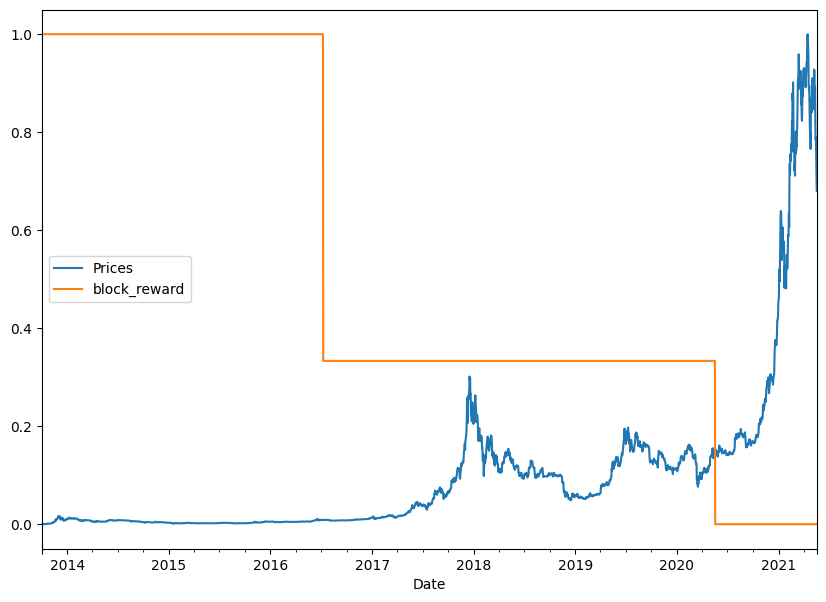

In [ ]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Prices", "block_reward"]]),
                                     columns = bitcoin_prices_block.columns,
                                     index = bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize = (10,7));

In [ ]:
HORIZON =1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

In [ ]:
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Prices+{i+1}"] = bitcoin_prices_windowed["Prices"].shift(periods = i+1)
bitcoin_prices_windowed.head(10)

,Prices,block_reward,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
X = bitcoin_prices_windowed.dropna().drop("Prices", axis = 1).astype(np.float)
Y = bitcoin_prices_windowed.dropna()["Prices"].astype(np.float32)

<ipython-input-37-3c4040246362>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = bitcoin_prices_windowed.dropna().drop("Prices", axis = 1).astype(np.float)


In [ ]:
split_size = int(len(X) * 0.8)
X_train, Y_train = X[:split_size], Y[:split_size]
X_test, Y_test = X[split_size:], Y[split_size:]


In [ ]:
tf.random.set_seed(42)
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = "relu"),
    #layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(HORIZON)
])

model_6.compile(loss = "mae", optimizer = tf.keras.optimizers.Adam(lr = 0.0003))
model_6.fit(X_train, Y_train, epochs = 100, batch_size = 128, validation_data = (X_test, Y_test), callbacks = [create_model_checkpoint(model_name = "model_6")])

Epoch 1/100
 1/18 [>.............................] - ETA: 10s - loss: 5988.8037

18/18 [==============================] - 1s 50ms/step - loss: 3747.6467 - val_loss: 11312.5215
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 698.1727 

18/18 [==============================] - 1s 44ms/step - loss: 694.2571 - val_loss: 3079.9727
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 426.4126

Exception ignored in: <function ConcreteFunctionGarbageCollector.__del__ at 0x7f39aedb2f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/monomorphic_function.py", line 2317, in __del__
    def __del__(self):
KeyboardInterrupt: 


18/18 [==============================] - 0s 29ms/step - loss: 277.1469 - val_loss: 1002.9174
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 240.4783

18/18 [==============================] - 0s 28ms/step - loss: 193.9753 - val_loss: 973.1026
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 191.2165

18/18 [==============================] - 0s 27ms/step - loss: 175.9152 - val_loss: 957.0472
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 129.9443

18/18 [==============================] - 1s 59ms/step - loss: 172.7534 - val_loss: 938.2614
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 167.5530 - val_loss: 950.6647
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 143.2793

18/18 [==============================] - 1s 30ms/step - loss: 163.6667 - val_loss: 898.8834
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 163.3372 - val_loss: 937.5763
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 173.5680

18/18 [==============================] - 0s 26ms/step - loss: 158.4911 - val_loss: 864.1175
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 169.6003

18/18 [==============================] - 0s 27ms/step - loss: 154.0314 - val_loss: 848.7307
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 150.5633 - val_loss: 900.3846
Epoch 13/100
18/18 [==============================] - 0s 3ms/step - loss: 149.6114 - val_loss: 875.8004
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 160.6583

18/18 [==============================] - 0s 26ms/step - loss: 145.4626 - val_loss: 834.0471
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 148.0022

18/18 [==============================] - 0s 26ms/step - loss: 143.0147 - val_loss: 803.8091
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 127.4482

18/18 [==============================] - 0s 27ms/step - loss: 139.0202 - val_loss: 802.2178
Epoch 17/100
18/18 [==============================] - 0s 3ms/step - loss: 137.5839 - val_loss: 839.9384
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 152.5393

KeyboardInterrupt: ignored

In [ ]:
model_6_pred = model_6.predict(X_test)
model_6_pred[:10]

18/18 [==============================] - 0s 2ms/step


array([[8603.872],
       [8546.068],
       [8791.251],
       [8568.257],
       [8527.004],
       [8468.767],
       [8461.231],
       [8305.476],
       [8217.296],
       [8302.415]], dtype=float32)

In [ ]:
model_6_result = evaluate_preds(Y_test, model_6_pred)

In [ ]:
model_6_result

{'mae': 16944.285,
 'mse': 600126900.0,
 'rmse': 23548.006,
 'mape': 110.580666,
 'mase': 29.766418}

In [ ]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
HORIZON = 1
WINDOW_SIZE =7


In [ ]:
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Prices"].shift(periods = i+1)

In [ ]:
X = bitcoin_prices_nbeats.dropna().drop("Prices", axis =1)
Y = bitcoin_prices_nbeats.dropna()["Prices"]

In [ ]:

split_size = int(len(X) * 0.8)
X_train, Y_train = X[:split_size], Y[:split_size]
X_test, Y_test = X[split_size:], Y[split_size:]

In [ ]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(Y_train)

In [ ]:
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(Y_test)

In [ ]:
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

In [ ]:
BATCH_SIZE = 1024

In [ ]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACK =30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

In [ ]:
tf.random.set_seed(42)
n_beat_block_layer = NBeatsBlock(input_size =INPUT_SIZE, theta_size = THETA_SIZE, horizon = HORIZON, n_neurons = N_NEURONS, n_layers = N_LAYERS, name = "Initial_block")


In [ ]:
stack_input = tf.keras.layers.Input(shape = (INPUT_SIZE), name = "stack_input")
residuals, forecast = n_beat_block_layer(stack_input)

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers
# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACK-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

KeyboardInterrupt: ignored

In [ ]:
def get_ensemble_models(horizon = HORIZON, train_data = train_dataset, test_data = test_dataset, num_iter = 10, num_epochs=  1000, loss_fn = ["mae", "mse", "mape"]):
  ensemble_models = []
  for i in range(num_iter):
    for loss_function in loss_fn:

      model = tf.keras.Sequential([
          tf.keras.layers.Dense(128, activation = "relu"),
          tf.keras.layers.Dense(128, activation = "relu"),
          tf.keras.layers.Dense(HORIZON)
      ])

      model.compile(loss = loss_function, optimizer = tf.keras.optimizers.Adam(), metrics = ["mae", "mse"])
      model.fit(train_dataset,
            epochs=num_epochs,
            validation_data=test_dataset,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

      ensemble_models.append(model)
  return ensemble_models



In [ ]:
get_ensemble_models(num_iter = 5, num_epochs = 10)

Epoch 1/10
3/3 [==============================] - 1s 68ms/step - loss: 1702.7390 - mae: 1702.7390 - mse: 6620907.5000 - val_loss: 4459.1128 - val_mae: 4459.1128 - val_mse: 36371928.0000 - lr: 0.0010
Epoch 2/10
3/3 [==============================] - 0s 9ms/step - loss: 290.2127 - mae: 290.2127 - mse: 260416.1094 - val_loss: 2386.9805 - val_mae: 2386.9805 - val_mse: 12752552.0000 - lr: 0.0010
Epoch 3/10
3/3 [==============================] - 0s 13ms/step - loss: 447.6785 - mae: 447.6784 - mse: 623338.7500 - val_loss: 1372.8008 - val_mae: 1372.8008 - val_mse: 5249749.0000 - lr: 0.0010
Epoch 4/10
3/3 [==============================] - 0s 10ms/step - loss: 171.0668 - mae: 171.0668 - mse: 143219.7656 - val_loss: 1483.6165 - val_mae: 1483.6165 - val_mse: 5185306.0000 - lr: 0.0010
Epoch 5/10
3/3 [==============================] - 0s 9ms/step - loss: 253.7209 - mae: 253.7209 - mse: 235619.3438 - val_loss: 1044.7598 - val_mae: 1044.7598 - val_mse: 2995439.0000 - lr: 0.0010
Epoch 6/10
3/3 [======

In [ ]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
ensemble_preds =  make_ensemble_preds(ensemble_models = ensemble_models, data = test_dataset)
ensemble_preds

NameError: ignored

In [ ]:
def get_upper_lower(preds):
  std = tf.math.reduce_std(preds, axis = 0)
  interval = 1.96*std
  preds_mean = tf.reduce_mean(preds, axis = 0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
lower, upper = get_upper_lower(preds = ensemble_preds)

NameError: ignored

In [ ]:
ensemble_median = np.median(ensemble_preds, axis = 0)

NameError: ignored

In [ ]:

x_all  = bitcoin_prices_windowed.dropna().drop(["Prices", "block_reward"], axis = 1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Prices"].to_numpy()

In [ ]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(x_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

In [ ]:
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

In [ ]:


BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

model_9 = tf.keras.Sequential([
    layers.Dense(128, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(HORIZON)
], name = "model_9_future_model")

model_9.compile(loss = tf.keras.losses.mae, optimizer = tf.keras.optimizers.Adam())

In [ ]:
model_9.fit(dataset_all, epochs = 100, callbacks = [create_model_checkpoint(model_name = model_9.name )])

Epoch 1/100
1/3 [=========>....................] - ETA: 9s - loss: 596.6933

3/3 [==============================] - 5s 11ms/step - loss: 7846.3311
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 460.9506

3/3 [==============================] - 0s 11ms/step - loss: 6247.3984
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 360.7229

3/3 [==============================] - 0s 12ms/step - loss: 4716.7559
Epoch 4/100
1/3 [=========>....................] - ETA: 0s - loss: 260.2482

3/3 [==============================] - 0s 16ms/step - loss: 3158.6726
Epoch 5/100
1/3 [=========>....................] - ETA: 0s - loss: 157.4774

3/3 [==============================] - 0s 13ms/step - loss: 1574.9858
Epoch 6/100
1/3 [=========>....................] - ETA: 0s - loss: 53.9870

3/3 [==============================] - 0s 12ms/step - loss: 404.7480
Epoch 7/100
1/3 [=========>....................] - ETA: 0s - loss: 46.5640

3/3 [==============================] - 0s 14ms/step - loss: 1073.8514
Epoch 8/100
1/3 [=========>....................] - ETA: 0s - loss: 77.3680

3/3 [==============================] - 0s 14ms/step - loss: 1040.5107
Epoch 9/100
1/3 [=========>....................] - ETA: 0s - loss: 56.7016

3/3 [==============================] - 0s 14ms/step - loss: 499.4262
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 20.2640

3/3 [==============================] - 0s 12ms/step - loss: 492.9488
Epoch 11/100
1/3 [=========>....................] - ETA: 0s - loss: 36.8116

3/3 [==============================] - 0s 11ms/step - loss: 653.6528
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 36.6681

3/3 [==============================] - 0s 10ms/step - loss: 468.6096
Epoch 13/100
1/3 [=========>....................] - ETA: 0s - loss: 20.2814

3/3 [==============================] - 0s 14ms/step - loss: 341.4681
Epoch 14/100
1/3 [=========>....................] - ETA: 0s - loss: 27.4019

3/3 [==============================] - 0s 13ms/step - loss: 442.4247
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 29.3627

3/3 [==============================] - 0s 13ms/step - loss: 355.4182
Epoch 16/100
1/3 [=========>....................] - ETA: 0s - loss: 19.3317

3/3 [==============================] - 0s 17ms/step - loss: 350.9602
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 20.9854

3/3 [==============================] - 0s 14ms/step - loss: 364.4394
Epoch 18/100
1/3 [=========>....................] - ETA: 0s - loss: 18.7134

3/3 [==============================] - 0s 18ms/step - loss: 303.9070
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 20.4149

3/3 [==============================] - 0s 9ms/step - loss: 333.7054
Epoch 20/100
1/3 [=========>....................] - ETA: 0s - loss: 21.3640

3/3 [==============================] - 0s 14ms/step - loss: 301.6046
Epoch 21/100
1/3 [=========>....................] - ETA: 0s - loss: 17.4970

3/3 [==============================] - 0s 13ms/step - loss: 311.4345
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 17.3649

3/3 [==============================] - 0s 13ms/step - loss: 287.7699
Epoch 23/100
1/3 [=========>....................] - ETA: 0s - loss: 17.8364

3/3 [==============================] - 0s 10ms/step - loss: 298.8578
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 18.8607

3/3 [==============================] - 0s 16ms/step - loss: 279.1239
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 16.3872

3/3 [==============================] - 0s 10ms/step - loss: 282.3502
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 16.1338

3/3 [==============================] - 0s 11ms/step - loss: 268.9930
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 17.0017

3/3 [==============================] - 0s 13ms/step - loss: 267.8094
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 16.0063

3/3 [==============================] - 0s 16ms/step - loss: 266.2602
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 15.5293

3/3 [==============================] - 0s 12ms/step - loss: 257.9057
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 16.0894

3/3 [==============================] - 0s 14ms/step - loss: 257.8018
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 15.6147

3/3 [==============================] - 0s 11ms/step - loss: 255.0703
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 15.1300

3/3 [==============================] - 0s 11ms/step - loss: 250.0765
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 15.5110

3/3 [==============================] - 0s 10ms/step - loss: 250.3934
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 15.2411

3/3 [==============================] - 0s 7ms/step - loss: 247.5798
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 14.8163

3/3 [==============================] - 0s 11ms/step - loss: 243.3894
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 15.1305

3/3 [==============================] - 0s 8ms/step - loss: 242.9549
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 14.8708

3/3 [==============================] - 0s 7ms/step - loss: 240.7647
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 14.6024

3/3 [==============================] - 0s 7ms/step - loss: 238.0100
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 14.7364

3/3 [==============================] - 0s 8ms/step - loss: 236.5355
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 14.5336

3/3 [==============================] - 0s 8ms/step - loss: 235.1765
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 14.5223

3/3 [==============================] - 0s 7ms/step - loss: 233.9391
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 14.5076

3/3 [==============================] - 0s 8ms/step - loss: 232.6765
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3984

3/3 [==============================] - 0s 7ms/step - loss: 231.2738
Epoch 44/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3935

3/3 [==============================] - 0s 10ms/step - loss: 230.6920
Epoch 45/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3254

3/3 [==============================] - 0s 10ms/step - loss: 229.7073
Epoch 46/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3246

3/3 [==============================] - 0s 7ms/step - loss: 229.3748
Epoch 47/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2612

3/3 [==============================] - 0s 7ms/step - loss: 228.9401
Epoch 48/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2583

3/3 [==============================] - 0s 8ms/step - loss: 230.1296
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2641

3/3 [==============================] - 0s 7ms/step - loss: 234.0234
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2130

3/3 [==============================] - 0s 7ms/step - loss: 243.7689
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2375

3/3 [==============================] - 0s 7ms/step - loss: 261.4633
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 14.4464

3/3 [==============================] - 0s 9ms/step - loss: 269.5242
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 14.5355

3/3 [==============================] - 0s 7ms/step - loss: 245.1822
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 14.9795

3/3 [==============================] - 0s 7ms/step - loss: 230.0579
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1671

3/3 [==============================] - 0s 7ms/step - loss: 225.1541
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3494

3/3 [==============================] - 0s 10ms/step - loss: 223.1089
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1067

3/3 [==============================] - 0s 9ms/step - loss: 222.7823
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1351

3/3 [==============================] - 0s 6ms/step - loss: 222.5563
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1135

3/3 [==============================] - 0s 9ms/step - loss: 222.5164
Epoch 60/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1190

3/3 [==============================] - 0s 9ms/step - loss: 223.3085
Epoch 61/100
1/3 [=========>....................] - ETA: 0s - loss: 14.0850

3/3 [==============================] - 0s 7ms/step - loss: 224.8533
Epoch 62/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1148

3/3 [==============================] - 0s 12ms/step - loss: 230.4569
Epoch 63/100
1/3 [=========>....................] - ETA: 0s - loss: 14.0720

3/3 [==============================] - 0s 7ms/step - loss: 238.8852
Epoch 64/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1145

3/3 [==============================] - 0s 8ms/step - loss: 261.8480
Epoch 65/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2080

3/3 [==============================] - 0s 8ms/step - loss: 276.3388
Epoch 66/100
1/3 [=========>....................] - ETA: 0s - loss: 14.5333

3/3 [==============================] - 0s 10ms/step - loss: 246.4307
Epoch 67/100
1/3 [=========>....................] - ETA: 0s - loss: 14.9724

3/3 [==============================] - 0s 8ms/step - loss: 226.5637
Epoch 68/100
1/3 [=========>....................] - ETA: 0s - loss: 14.0011

3/3 [==============================] - 0s 7ms/step - loss: 221.1623
Epoch 69/100
1/3 [=========>....................] - ETA: 0s - loss: 14.0863

3/3 [==============================] - 0s 8ms/step - loss: 219.7430
Epoch 70/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9489

3/3 [==============================] - 0s 9ms/step - loss: 219.7039
Epoch 71/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9586

3/3 [==============================] - 0s 8ms/step - loss: 220.0685
Epoch 72/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9276

3/3 [==============================] - 0s 7ms/step - loss: 221.0984
Epoch 73/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9239

3/3 [==============================] - 0s 9ms/step - loss: 223.1379
Epoch 74/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9389

3/3 [==============================] - 0s 7ms/step - loss: 230.7047
Epoch 75/100
1/3 [=========>....................] - ETA: 0s - loss: 13.8585

3/3 [==============================] - 0s 8ms/step - loss: 252.8493
Epoch 76/100
1/3 [=========>....................] - ETA: 0s - loss: 13.8361

3/3 [==============================] - 0s 7ms/step - loss: 260.4143
Epoch 77/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2745

3/3 [==============================] - 0s 11ms/step - loss: 261.2618
Epoch 78/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1724

3/3 [==============================] - 0s 10ms/step - loss: 239.0936
Epoch 79/100
1/3 [=========>....................] - ETA: 0s - loss: 14.3746

3/3 [==============================] - 0s 11ms/step - loss: 229.2746
Epoch 80/100
1/3 [=========>....................] - ETA: 0s - loss: 13.8073

3/3 [==============================] - 0s 8ms/step - loss: 232.8177
Epoch 81/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9064

3/3 [==============================] - 0s 8ms/step - loss: 242.1819
Epoch 82/100
1/3 [=========>....................] - ETA: 0s - loss: 13.7880

3/3 [==============================] - 0s 9ms/step - loss: 247.9567
Epoch 83/100
1/3 [=========>....................] - ETA: 0s - loss: 14.2083

3/3 [==============================] - 0s 8ms/step - loss: 245.2897
Epoch 84/100
1/3 [=========>....................] - ETA: 0s - loss: 13.8685

3/3 [==============================] - 0s 7ms/step - loss: 235.8172
Epoch 85/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1434

3/3 [==============================] - 0s 12ms/step - loss: 232.0343
Epoch 86/100
1/3 [=========>....................] - ETA: 0s - loss: 13.7648

3/3 [==============================] - 0s 9ms/step - loss: 234.7061
Epoch 87/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9563

3/3 [==============================] - 0s 9ms/step - loss: 239.3050
Epoch 88/100
1/3 [=========>....................] - ETA: 0s - loss: 13.7546

3/3 [==============================] - 0s 8ms/step - loss: 240.1510
Epoch 89/100
1/3 [=========>....................] - ETA: 0s - loss: 14.1306

3/3 [==============================] - 0s 8ms/step - loss: 236.7231
Epoch 90/100
1/3 [=========>....................] - ETA: 0s - loss: 13.7459

3/3 [==============================] - 0s 11ms/step - loss: 236.5479
Epoch 91/100
1/3 [=========>....................] - ETA: 0s - loss: 14.0036

3/3 [==============================] - 0s 7ms/step - loss: 237.9847
Epoch 92/100
1/3 [=========>....................] - ETA: 0s - loss: 13.7402

3/3 [==============================] - 0s 7ms/step - loss: 236.9349
Epoch 93/100
1/3 [=========>....................] - ETA: 0s - loss: 14.0536

3/3 [==============================] - 0s 8ms/step - loss: 235.0385
Epoch 94/100
1/3 [=========>....................] - ETA: 0s - loss: 13.7244

3/3 [==============================] - 0s 8ms/step - loss: 234.2646
Epoch 95/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9778

3/3 [==============================] - 0s 7ms/step - loss: 234.7633
Epoch 96/100
1/3 [=========>....................] - ETA: 0s - loss: 13.7078

3/3 [==============================] - 0s 7ms/step - loss: 235.6328
Epoch 97/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9734

3/3 [==============================] - 0s 7ms/step - loss: 236.1345
Epoch 98/100
1/3 [=========>....................] - ETA: 0s - loss: 13.7099

3/3 [==============================] - 0s 8ms/step - loss: 234.1112
Epoch 99/100
1/3 [=========>....................] - ETA: 0s - loss: 13.9986

3/3 [==============================] - 0s 7ms/step - loss: 232.0389
Epoch 100/100
1/3 [=========>....................] - ETA: 0s - loss: 13.6845

3/3 [==============================] - 0s 8ms/step - loss: 232.4589


In [ ]:
INFO_FUTURE = 14
model_9.summary()

Model: "model_9_future_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_124 (Dense)           (None, 128)               1024      
                                                                 
 dense_125 (Dense)           (None, 128)               16512     
                                                                 
 dense_126 (Dense)           (None, 1)                 129       
                                                                 
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def make_future_predictions(values, model, into_future, window_size = WINDOW_SIZE)->list:
  future_forecst = []
  last_window = values[-WINDOW_SIZE:]

  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis = 0))

    future_forecst.append(tf.squeeze(future_pred).numpy())

    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  return future_forecst

In [ ]:
future_forecast = make_future_predictions(values = y_all, model = model_9, into_future = INFO_FUTURE, window_size =WINDOW_SIZE)

1/1 [==============================] - 0s 25ms/step


In [ ]:
future_forecast

[55779.812,
 50915.418,
 49309.402,
 49584.098,
 47204.5,
 44896.383,
 49154.242,
 54395.6,
 49717.85,
 49334.465,
 49084.02,
 46434.46,
 47121.848,
 52017.926]

In [ ]:
def get_future_dates(start_date, into_future, offset =1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date)

In [ ]:
next_time_steps = get_future_dates(start_date = bitcoin_prices.index[-1], into_future = INFO_FUTURE)

NameError: ignored

In [ ]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])

NameError: ignored

In [ ]:
plt.figure(figsize = (10,7))
plot_time_series(bitcoin_prices.index, btc_price, start = 2500, format = "-", label = "Actual BTC Price")
plot_time_series(next_time_steps, future_fotrecast, format = "-", label = "Predicted BTC Price")

In [ ]:
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

NameError: ignored

In [ ]:
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

NameError: ignored

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

NameError: ignored

In [ ]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

NameError: ignored

In [ ]:
turkey_model = tf.keras.clone_model(model_1)
turkey_model.__name = "Turkey Model"
turkey_model.compile(loss = "mae", optimizer = tf.keras.optimizers.Adam(lr = 0.001))
turkey_model.fit(X_train, y_train, epochs =100, batch_size = 128, validation_data = (X_test, y_test), callbacks = [create_model_checkpoint(turkey_model.name)])

In [ ]:
turkey_model.evaluate(X_test, y_test)


NameError: ignored

In [ ]:
turkey_preds = make_preds(turkey_model, X_test)


NameError: ignored

In [ ]:
turkey_result = evaluate_preds(y_test, turkey_preds)

NameError: ignored

In [ ]:
import tensorflow as tf

# Define a tensor
tensor = tf.constant([[[1, 2], [3, 4]], [[5, 6], [7, 8]], [[9, 10], [11, 12]]])

# Compute the mean along axis 0
mean_tensor = tf.reduce_mean(tensor, axis=0)

print(mean_tensor)


tf.Tensor(
[[5 6]
 [7 8]], shape=(2, 2), dtype=int32)
